In [1]:
import json
import js 
from js import fetch
import pandas as pd
from datetime import datetime
from pyodide.ffi import to_js
from js import Object

# Special packages already ready
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# Custom importations from special package
# Below stuff to be shortened
import piplite
await piplite.install("mplfinance")
import mplfinance as mpf
%pip install jinja2

---

# 02 Hammer Formation

## About
A Bullish hammer is formed at the end of a downward rally. It displays a reverse in the downwards movement of a stock.

## Usage
Click the >> (Run all steps) icon above to run this script

## What
This script provides you with an ability to determine the Bullish hammer cadlestick pattern. The script has been explained in [this](https://zerodha.com/varsity/chapter/single-candlestick-patterns-part-3/) blog post by Karthik Rangappa.
*Note: Values are changed, feel free to change them*

---

## Grabbing data

***The data being provisioned is only for educational purposes***


*Note: You can use the free service limits usage to only 100 symbols per minute. Tampering with this system will result in discontinuation of the service*

## Adding symbols

Please feel free to add any **NSE SYMBOL** to the below list

In [2]:
symbols = "ADANIENT,ADANIPORTS,APOLLOHOSP,ASIANPAINT,AXISBANK,\
BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BHARTIARTL,BPCL,BRITANNIA,\
CIPLA,COALINDIA,\
DIVISLAB,DRREDDY,\
EICHERMOT,\
GRASIM,\
HCLTECH,HDFC,HDFCBANK,HDFCLIFE,HEROMOTOCO,HINDALCO,HINDUNILVR,\
ICICIBANK,INDUSINDBK,INFY,ITC,\
JSWSTEEL,\
KOTAKBANK,\
LT,\
M&M,MARUTI,\
NESTLEIND,NTPC,\
ONGC,\
POWERGRID,\
RELIANCE,\
SBIN,SBILIFE,SUNPHARMA,\
TATAMOTORS,TATASTEEL,TCS,TATACONSUM,TECHM,TITAN,\
ULTRACEMCO,UPL,\
WIPRO"

In [3]:
corsprox = "https://corsproxy.io/?"
apiBaseURL = "https://query1.finance.yahoo.com/v8/finance/chart/"
rangeOfData = "1mo"
intervalOfData = "1d"
apiSymbol = []
for symbol in symbols.split(","):
    apiSymbol.append(symbol+".NS")
stockPandasTot = {}
for apiSymbolIndivi in apiSymbol:
    print(apiSymbolIndivi)
    apiCompleteURL = corsprox+apiBaseURL+apiSymbolIndivi+\
        "?range="+rangeOfData+"&interval="+intervalOfData
    resp = await js.fetch(apiCompleteURL, to_js({
                    "mode": "cors",
                    "credentials":"omit",
                    "headers": {'Accept': 'application/json',
                                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
                                'Origin':'https://yahoo.com',
                                }
                    }, dict_converter=Object.fromEntries))
    text = await resp.text()
    pan = pd.read_json(text)
    a_hist = pan['chart'][1][0]
    stockPandas = pd.DataFrame(a_hist['indicators']['quote'][0],
                               index=pd.to_datetime(a_hist['timestamp'],unit='s'))
    stockPandas = stockPandas.reindex(columns=['open','high','low','close','volume'])
    stockPandas = stockPandas[::-1]
    stockPandasTot[apiSymbolIndivi] = stockPandas.round(2)
# Uncomment below line to show data
# stockPandasTot

ADANIENT.NS
ADANIPORTS.NS
APOLLOHOSP.NS
ASIANPAINT.NS
AXISBANK.NS
BAJAJ-AUTO.NS
BAJFINANCE.NS
BAJAJFINSV.NS
BHARTIARTL.NS
BPCL.NS
BRITANNIA.NS
CIPLA.NS
COALINDIA.NS
DIVISLAB.NS
DRREDDY.NS
EICHERMOT.NS
GRASIM.NS
HCLTECH.NS
HDFC.NS
HDFCBANK.NS
HDFCLIFE.NS
HEROMOTOCO.NS
HINDALCO.NS
HINDUNILVR.NS
ICICIBANK.NS
INDUSINDBK.NS
INFY.NS
ITC.NS
JSWSTEEL.NS
KOTAKBANK.NS
LT.NS
M&M.NS
MARUTI.NS
NESTLEIND.NS
NTPC.NS
ONGC.NS
POWERGRID.NS
RELIANCE.NS
SBIN.NS
SBILIFE.NS
SUNPHARMA.NS
TATAMOTORS.NS
TATASTEEL.NS
TCS.NS
TATACONSUM.NS
TECHM.NS
TITAN.NS
ULTRACEMCO.NS
UPL.NS
WIPRO.NS


## Hammer formation

[![A Bullish Hammer](https://www.daytradetheworld.com/wp-content/uploads/2020/05/bullish-hammer-1.png)](https://www.daytradetheworld.com/wp-content/uploads/2020/05/bullish-hammer-1.png)

A bullish hammer is formed at the bootom of a downtrend also indicating there is a trend reversal. 

### Parameters
A bullish hammer signal occurs on day 0.

Interprating from the blog entry above we have 

- A downward trend required 
    - Currently not implemented
- Current colour of candle unimportant
    - $Close > Open || Open > Close$
- Upper shadow within 0.3%
- Lower shadow greater than 2% 
- dates weightages are till day 3 as follows
    - day0: 15
    - day1: 10
    - day2: 5
    - day3: 2


In [4]:
## Variables
# Number of days checked [Can we push this dates checked to different cell?]
datesChecked = 16
# weights of each individual day (Shape in reshape function should be matched. )
weights = np.array([15, 10, 5, 2])
# Adding additional weights, will be helfull only while checking.
weights = np.append(weights, np.ones((datesChecked-4,1)))
signalHammerDict = {}

---
### Displaying results 
In this section we shall see the various manners that we can display the results

The below dataframe shows how the bullish signal has appeared on the chart for the past 50 days

In [5]:
for symbol in stockPandasTot:
    selectData = stockPandasTot[symbol].to_numpy()
    signalHammer = np.zeros(datesChecked)
    for i in range(datesChecked) :
        row = selectData[i,:]
        # The rows have open, high, low, close volume data
        # Since colour is unimportant, we are taking the 
        # lower and higher points
        # of candlestick
        canOpen = row[0]
        canHigh = row[1]
        canLow = row[2]
        canClose = row[3]
        if canOpen >= canClose:
            higherCan = canOpen
            lowerCan = canClose
        else:
            lowerCan = canOpen
            higherCan = canClose
        upperShadow = (canHigh - higherCan)
        lowerShadow = (lowerCan - canLow)
        if upperShadow / canClose < 0.003:
            if lowerShadow / canClose > 0.01:
                if (higherCan-lowerCan) / canClose < 0.005:
                    signalHammer[i] = 1
    signalHammer = weights*signalHammer
    signalHammerDict[symbol] = signalHammer

---
### Displaying results 
In this section we shall see the various manners that we can display the results

The below dataframe shows how the bullish signal has appeared on the chart for the past 50 days

In [6]:
signalBullPand = pd.DataFrame(signalHammerDict).T

def color_mapper(row):
    # compute the sum of the row
    sum = row.sum()
    # if the sum is negative, return red
    if sum < 0:
        return ['color: white; background-color: rgb(120, 50, 20)'] * len(row)
    # if the sum is positive, map it to a shade of green based on its magnitude
    else:
        magnitude = sum*10
        r = 15
        g = magnitude
        b = 15
        return [f'color: white; background-color: rgb({r},{g},{b})'] * len(row)

def make_pretty(styler):
    styler.apply(color_mapper,axis=1)
    styler.format(precision=1)
    return styler

signalBullPand.style.pipe(make_pretty)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ADANIENT.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADANIPORTS.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APOLLOHOSP.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ASIANPAINT.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AXISBANK.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAJAJ-AUTO.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAJFINANCE.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAJAJFINSV.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BHARTIARTL.NS,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
BPCL.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Plotting
Innumerous plotting is possible with several methods I prefer the mplfinance package, but others will be easily implemented. Here you can see the volumes, 
moving averages and candlebar.

ADANIENT.NS


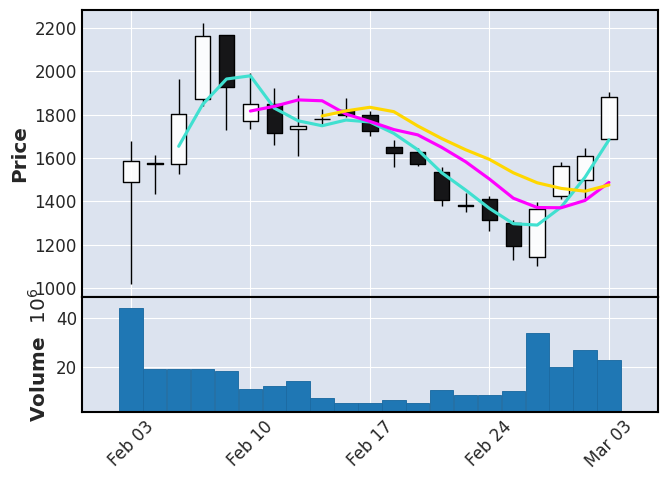

ADANIPORTS.NS


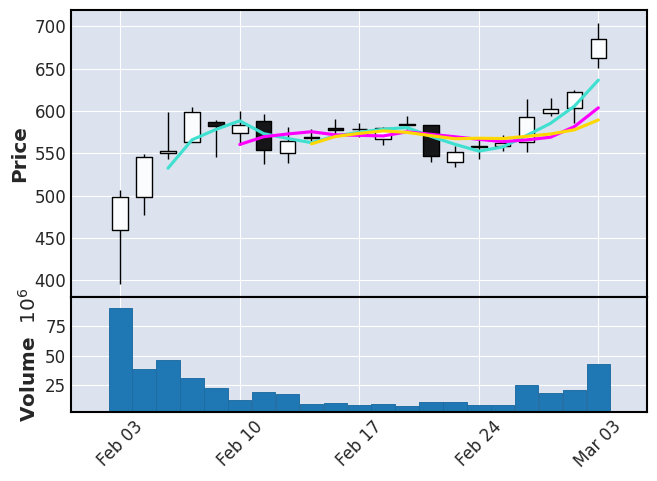

APOLLOHOSP.NS


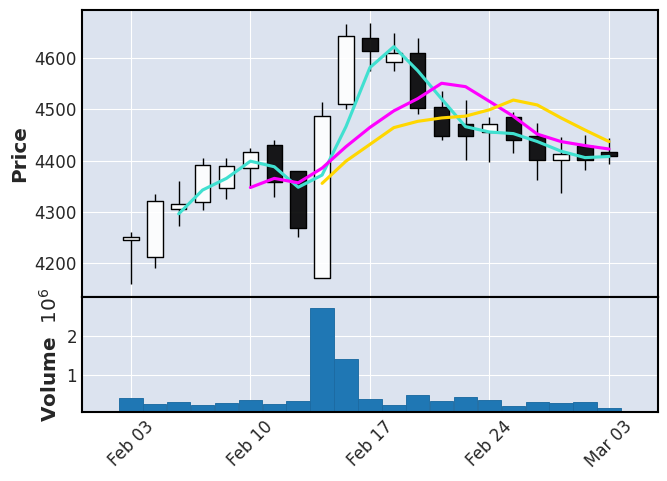

ASIANPAINT.NS


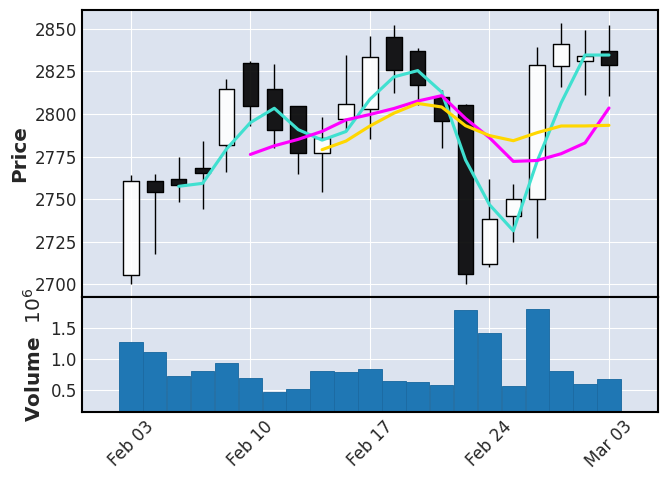

AXISBANK.NS


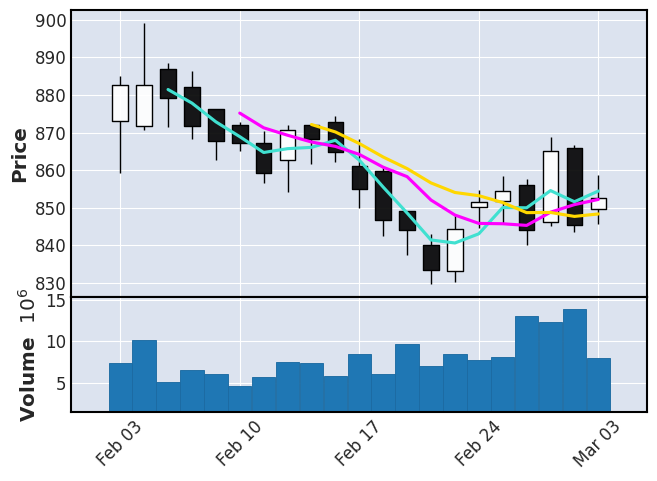

BAJAJ-AUTO.NS


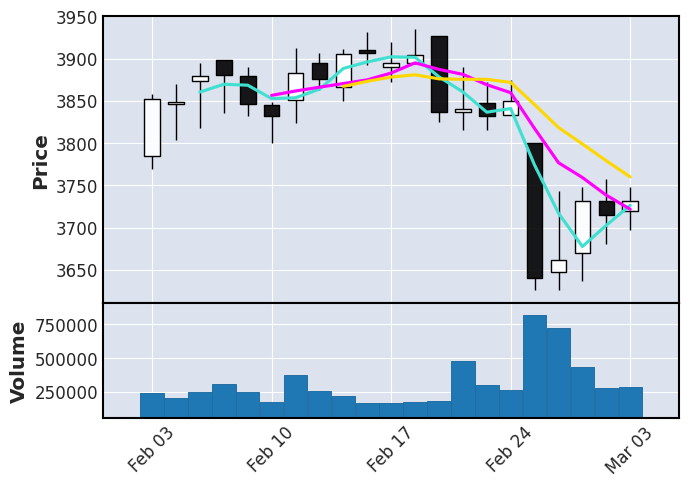

BAJFINANCE.NS


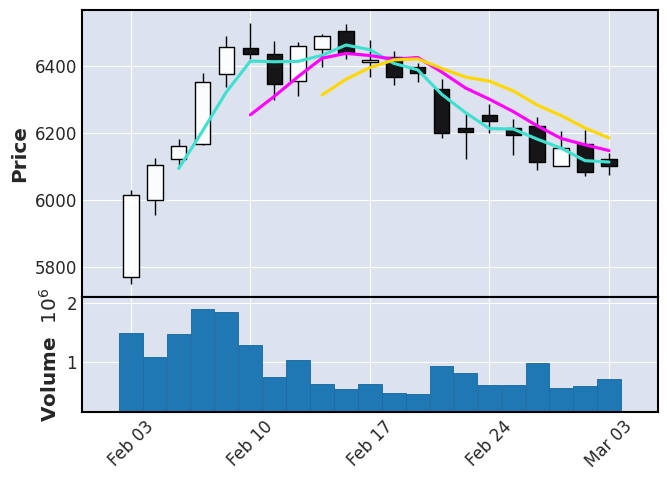

BAJAJFINSV.NS


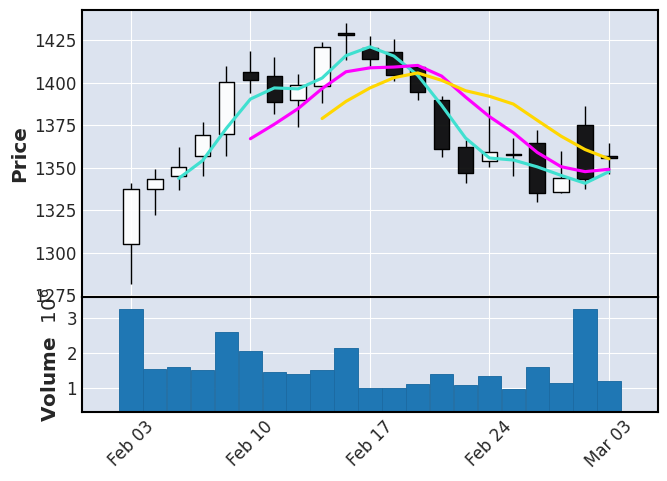

BHARTIARTL.NS


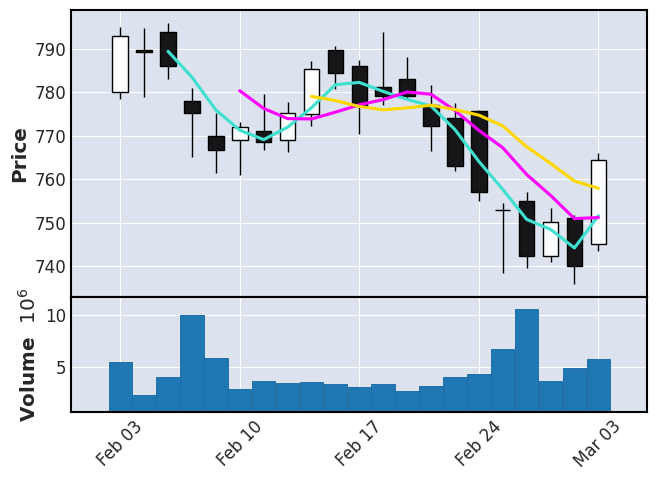

BPCL.NS


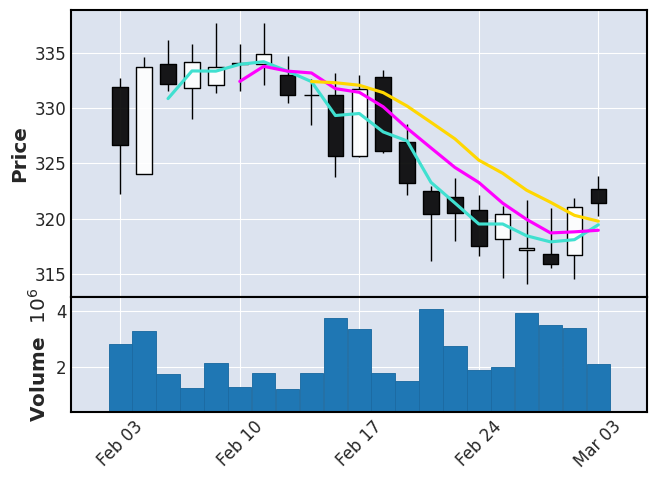

BRITANNIA.NS


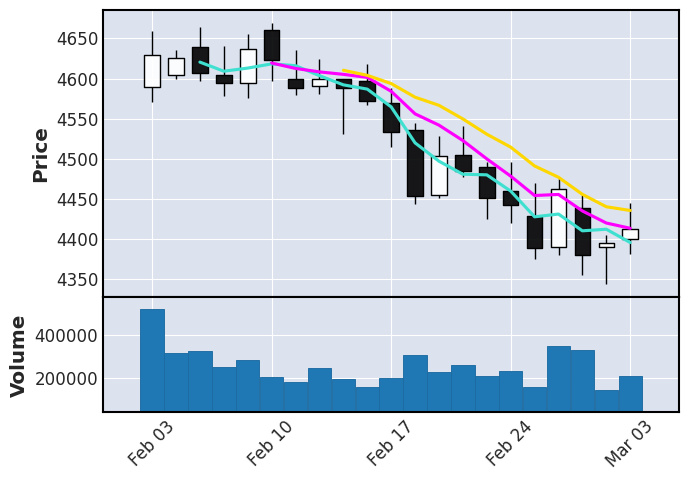

CIPLA.NS


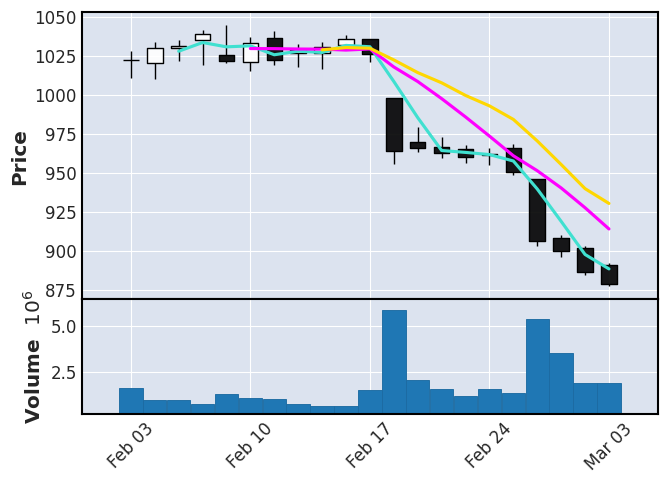

COALINDIA.NS


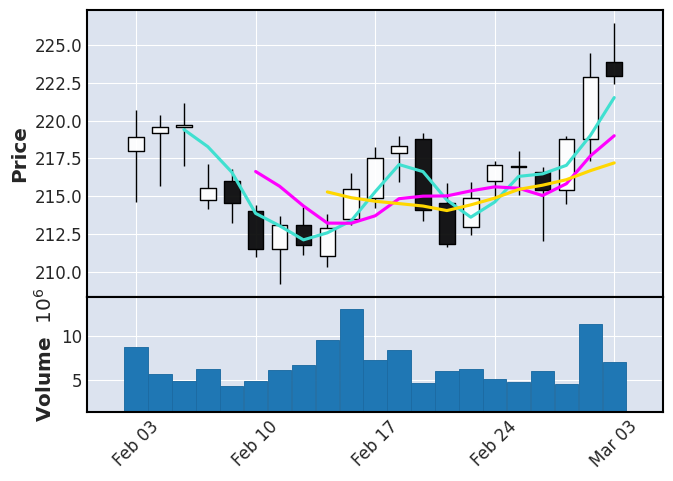

DIVISLAB.NS


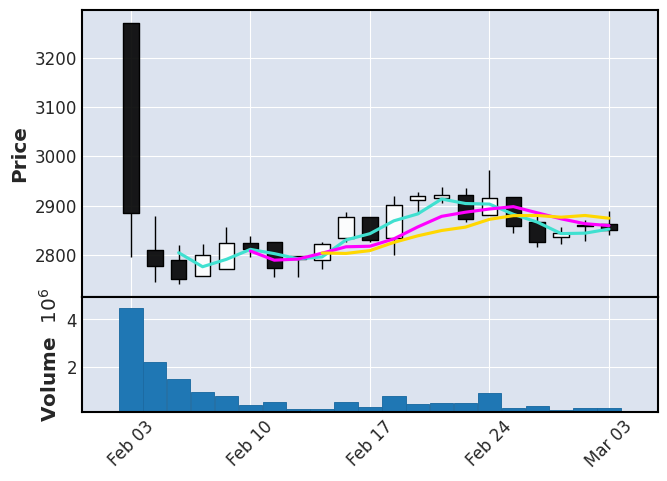

DRREDDY.NS


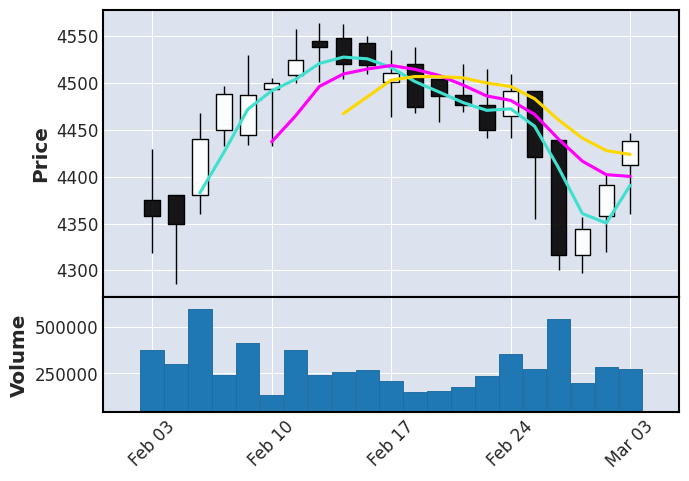

EICHERMOT.NS


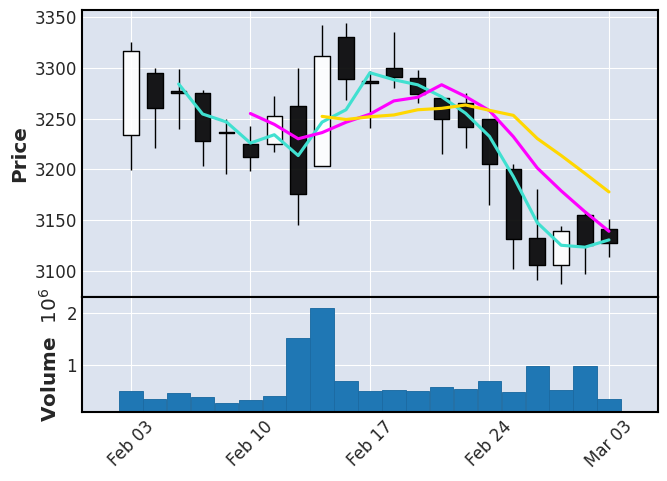

GRASIM.NS


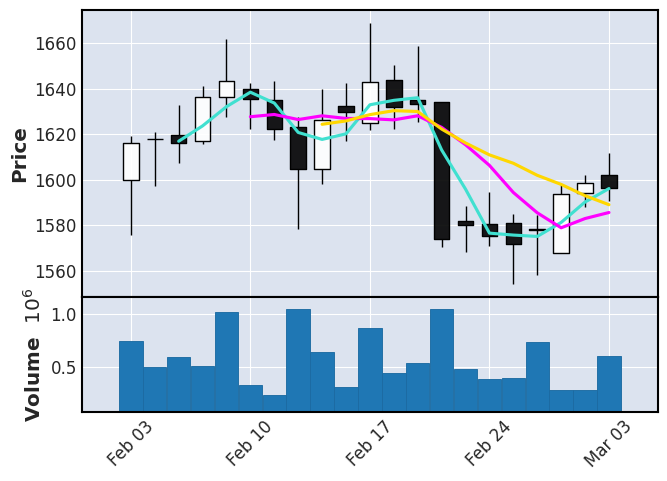

HCLTECH.NS


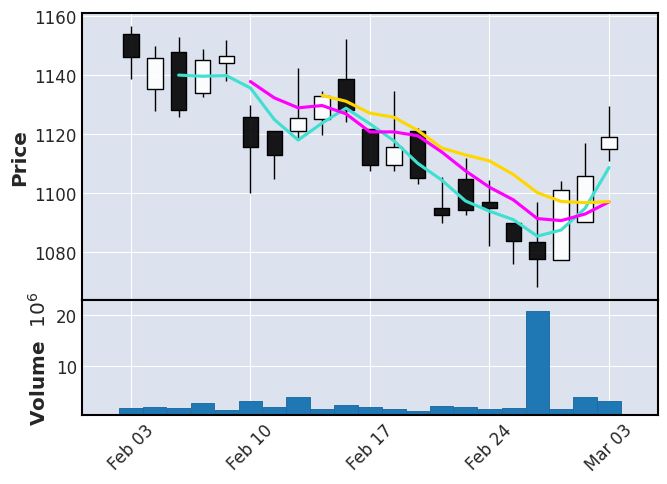

HDFC.NS


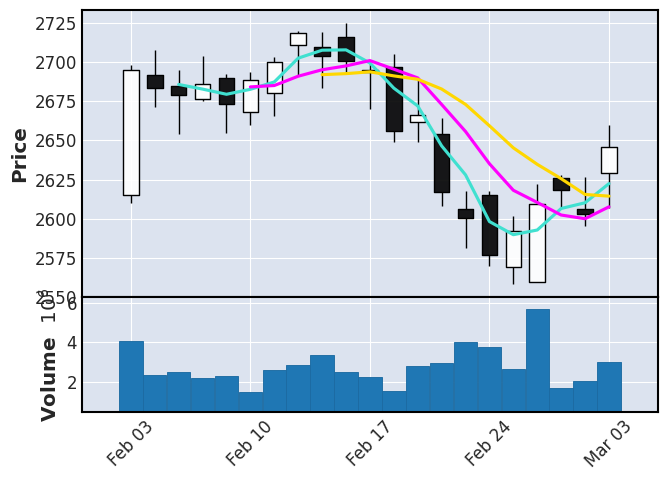

HDFCBANK.NS


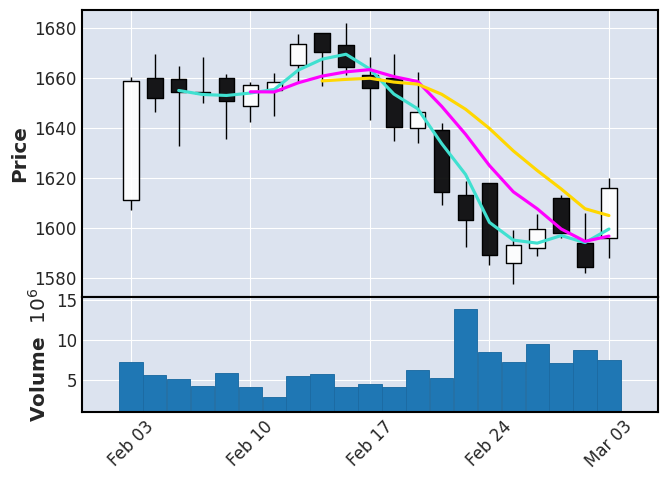

HDFCLIFE.NS


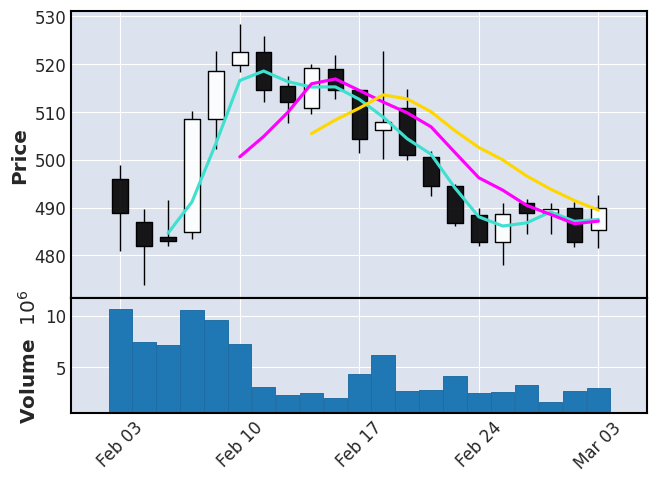

HEROMOTOCO.NS


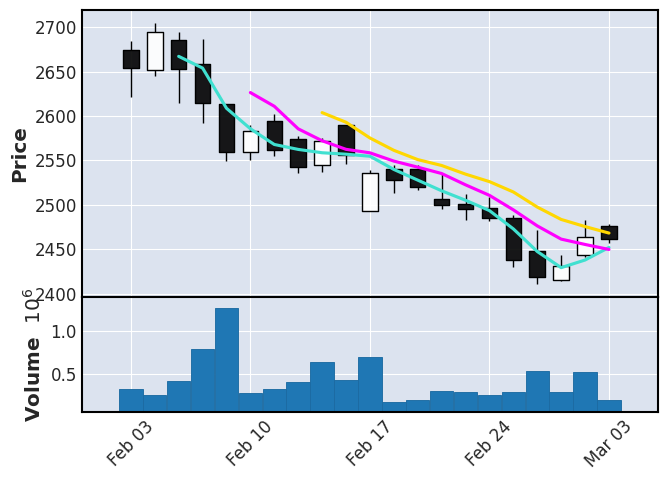

HINDALCO.NS


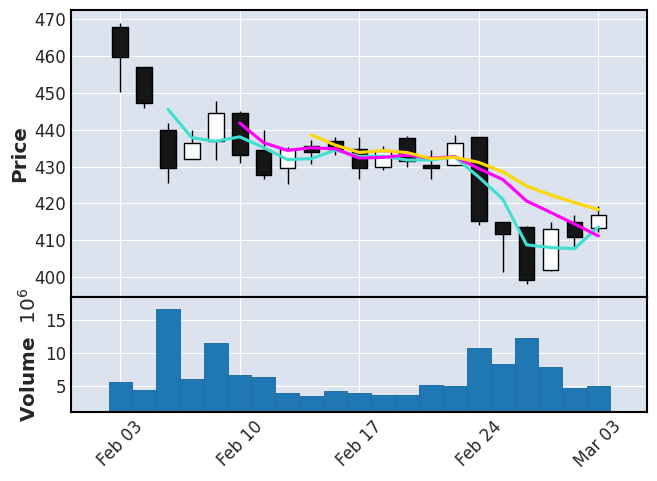

HINDUNILVR.NS


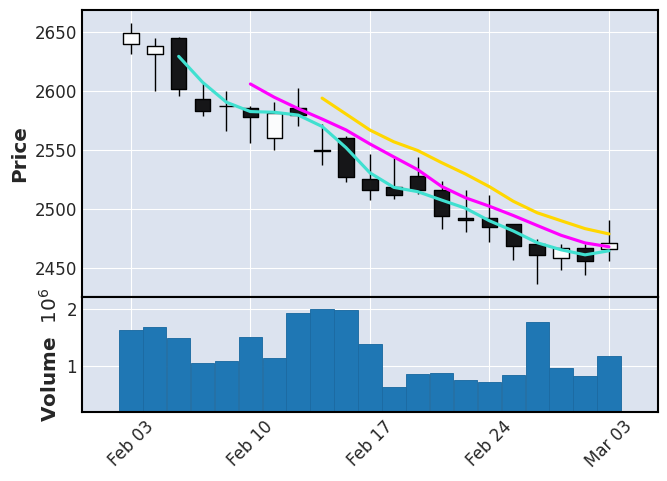

ICICIBANK.NS


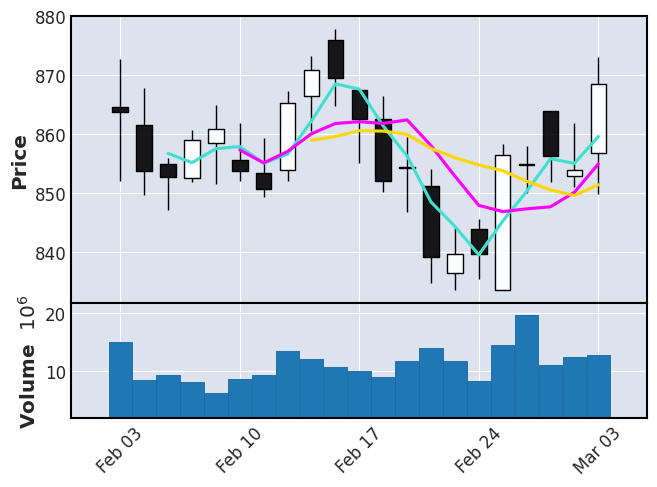

INDUSINDBK.NS


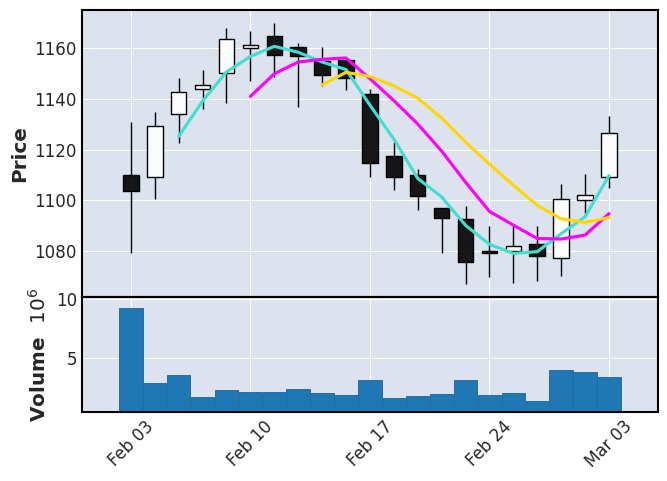

INFY.NS


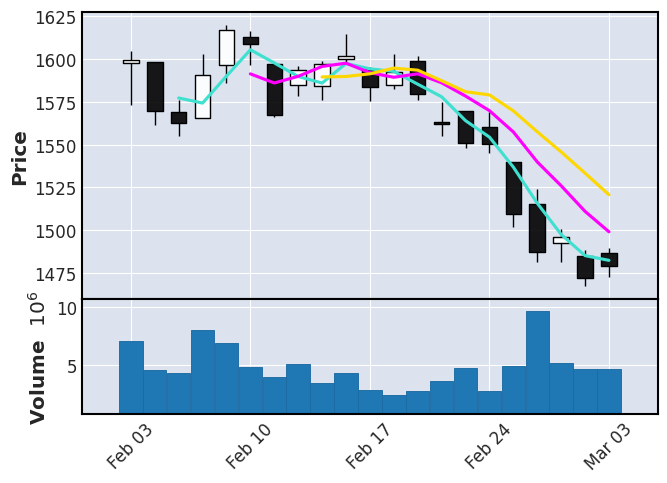

ITC.NS


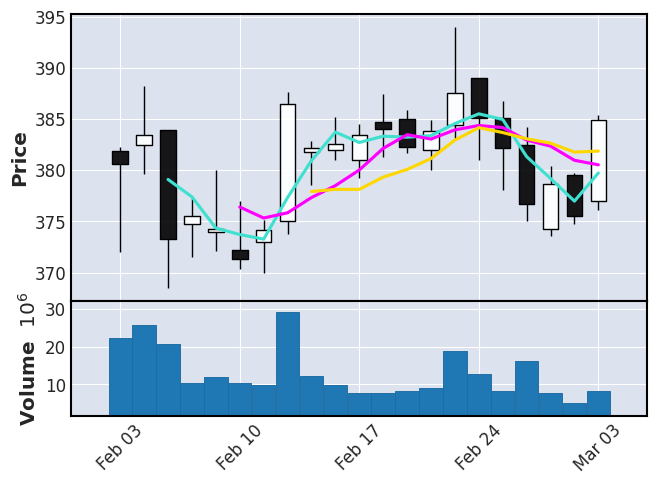

JSWSTEEL.NS


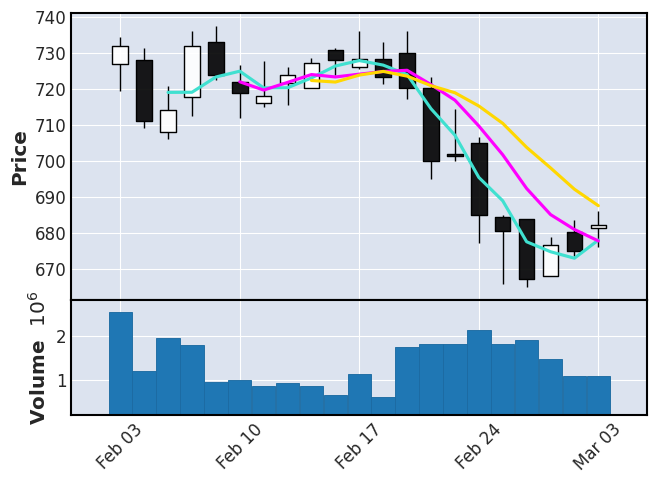

KOTAKBANK.NS


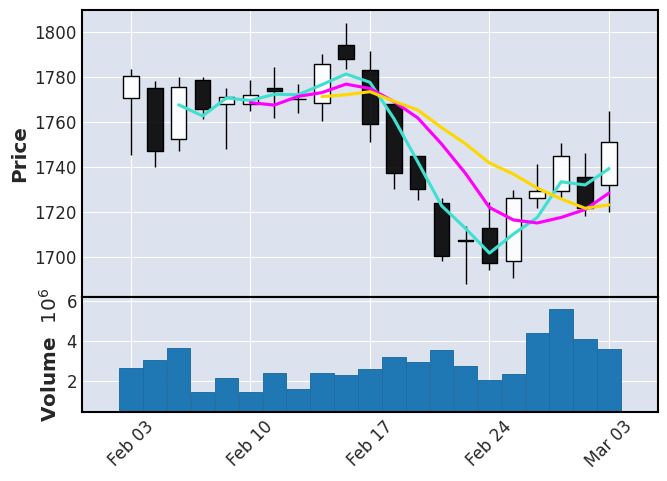

LT.NS


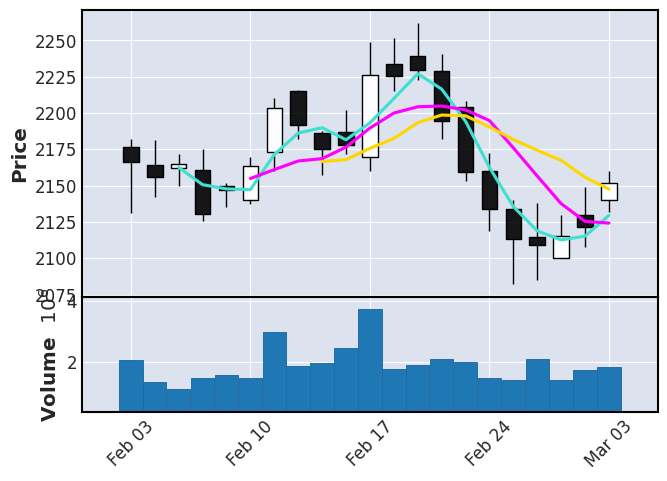

M&M.NS


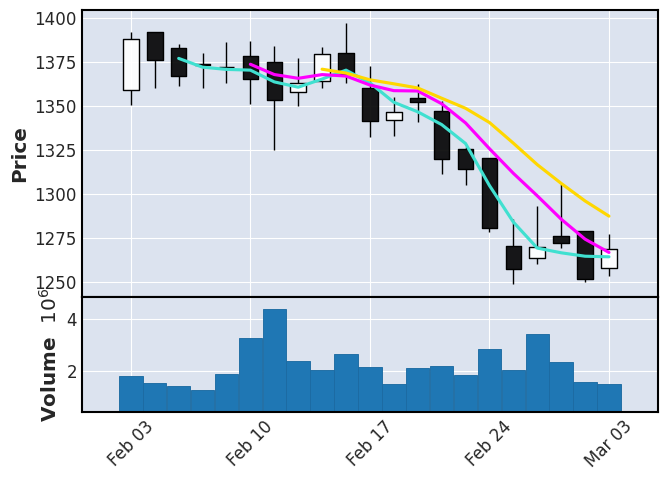

MARUTI.NS


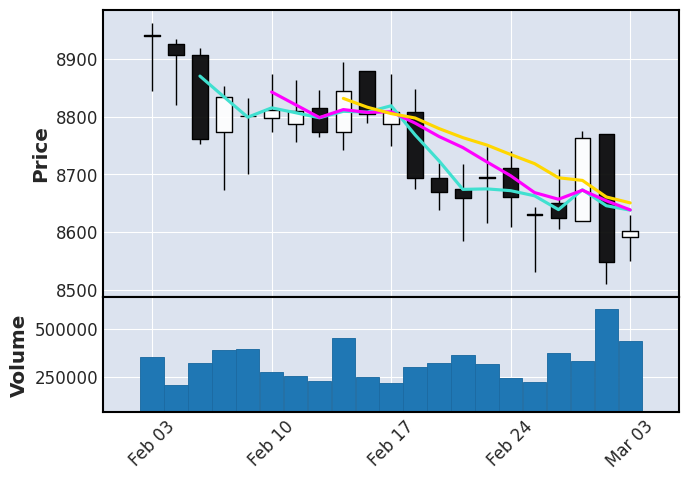

NESTLEIND.NS


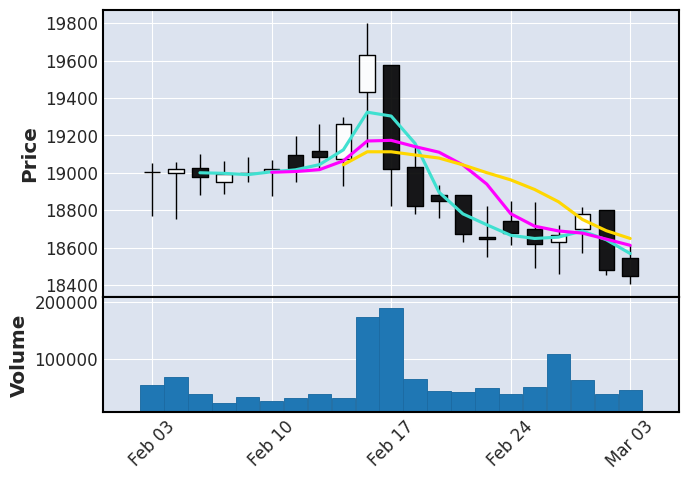

NTPC.NS


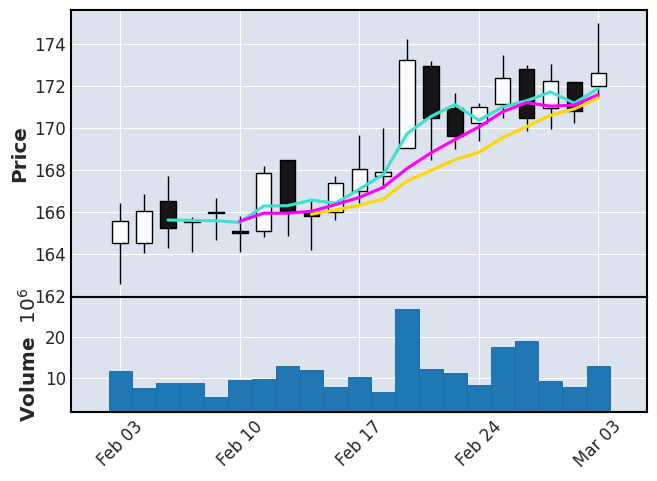

ONGC.NS


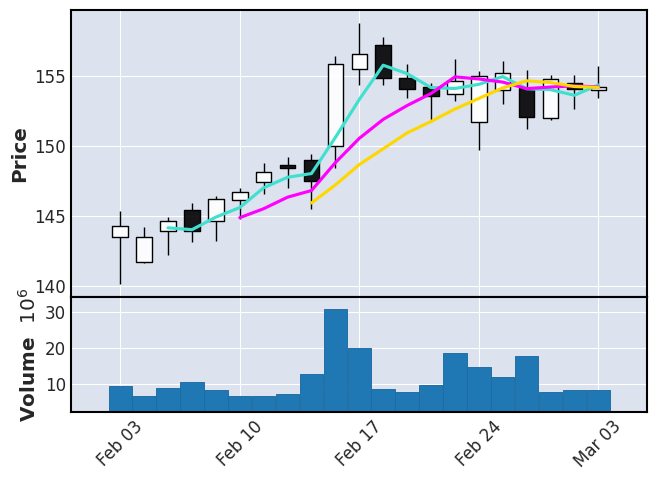

POWERGRID.NS


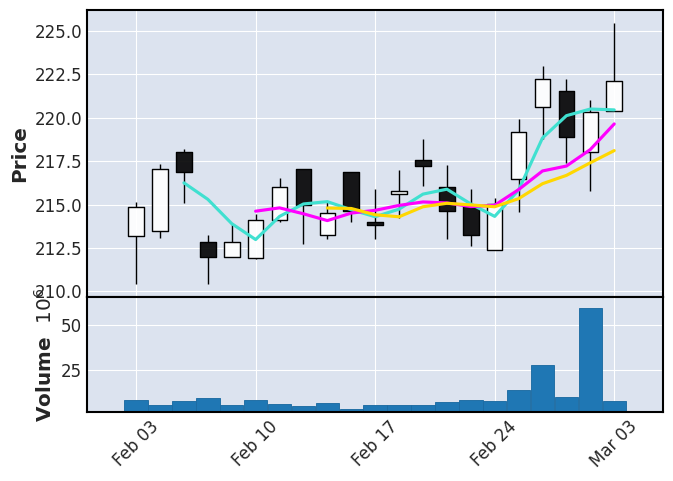

RELIANCE.NS


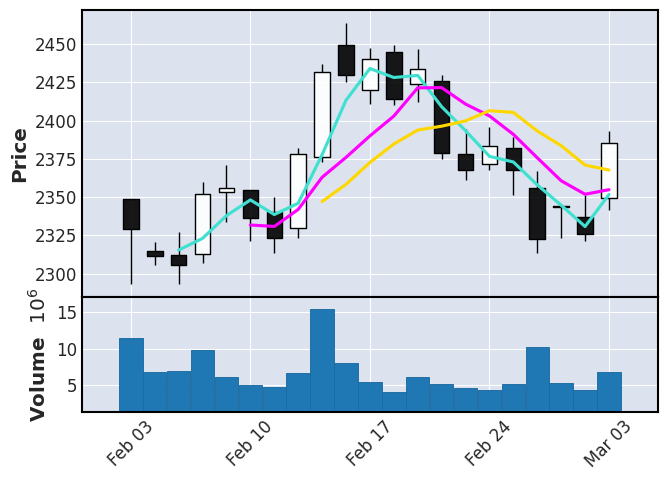

SBIN.NS


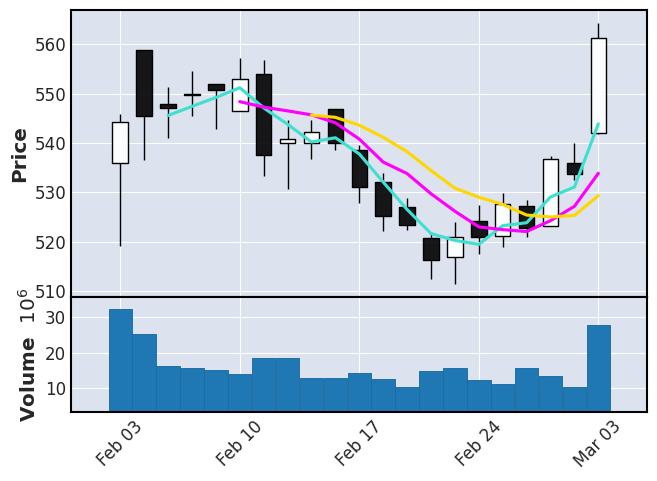

SBILIFE.NS


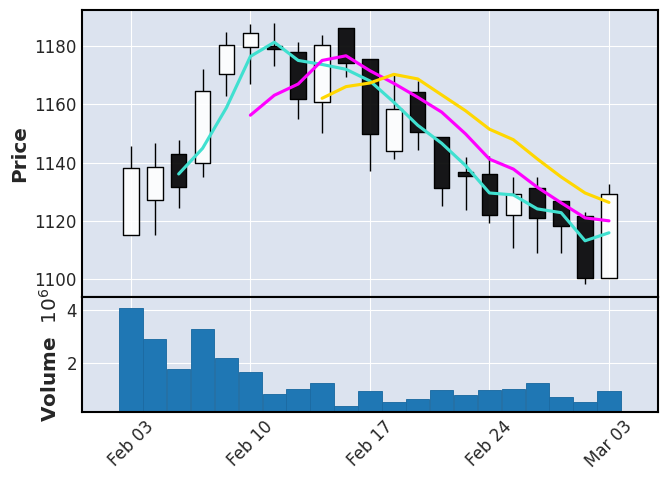

SUNPHARMA.NS


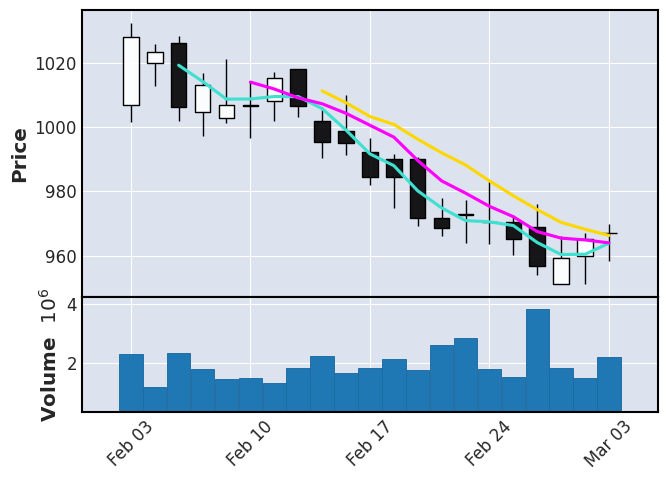

TATAMOTORS.NS


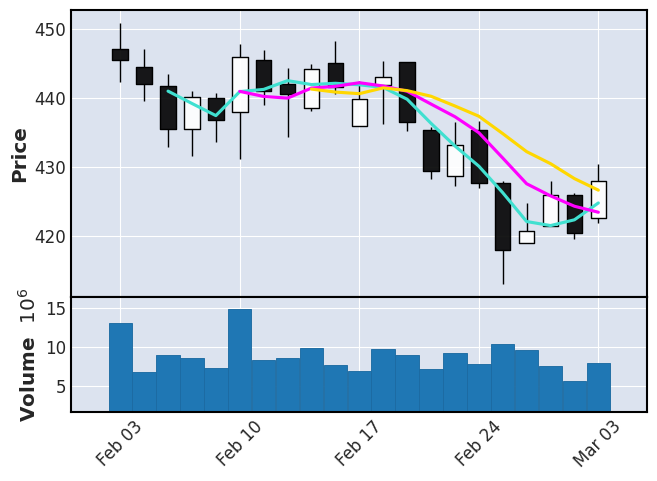

TATASTEEL.NS


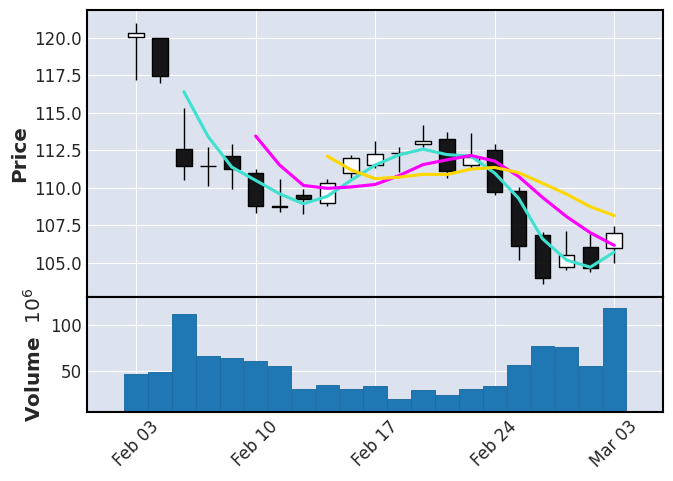

TCS.NS


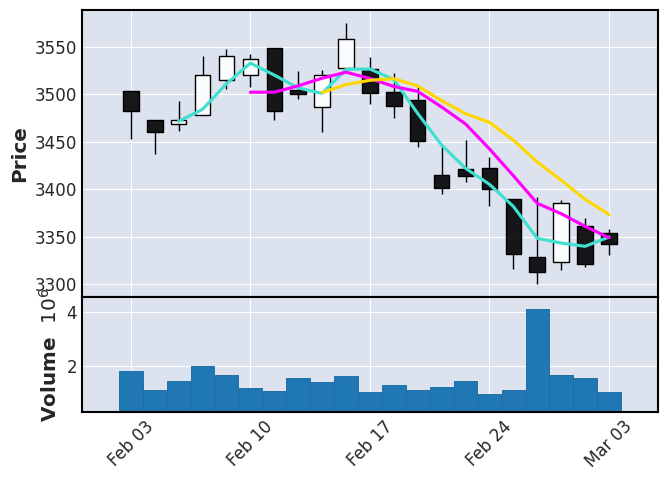

TATACONSUM.NS


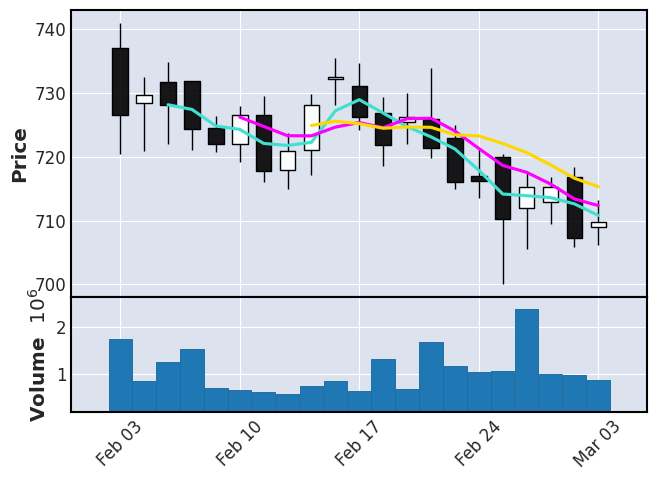

TECHM.NS


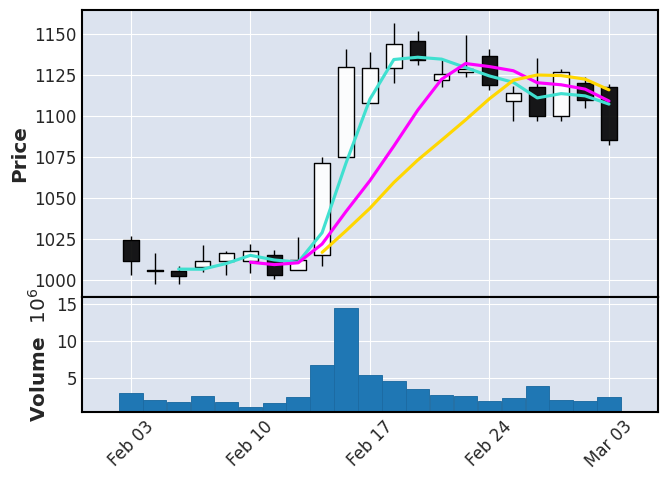

TITAN.NS


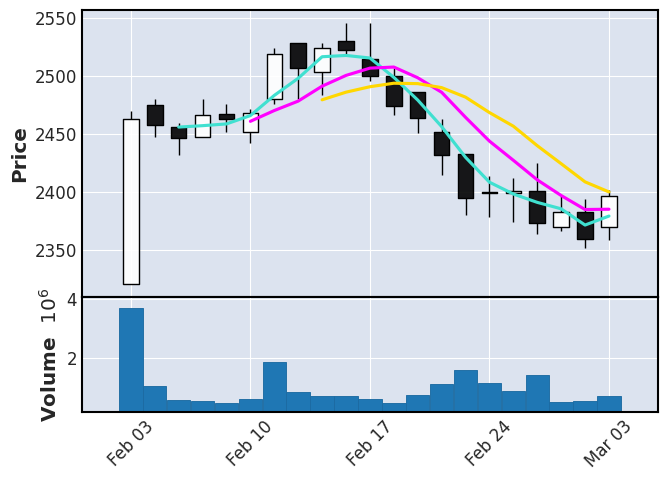

ULTRACEMCO.NS


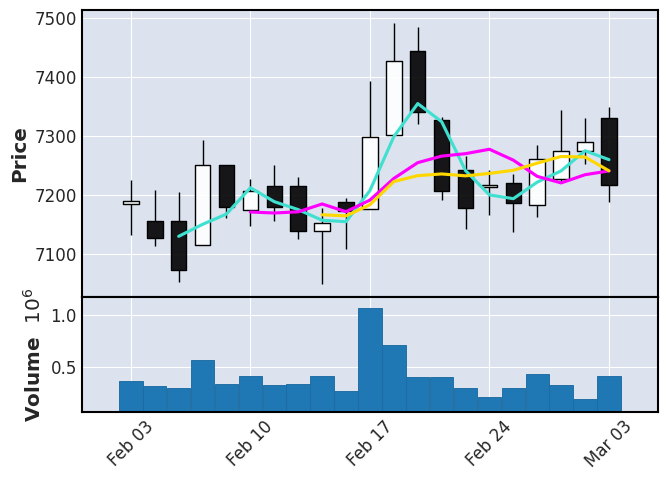

UPL.NS


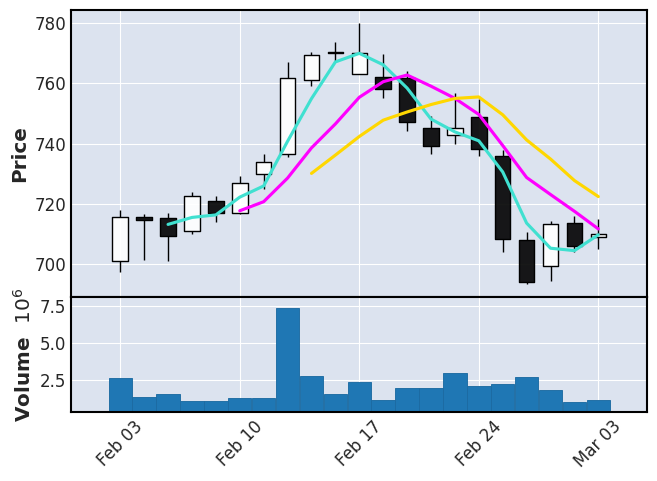

WIPRO.NS


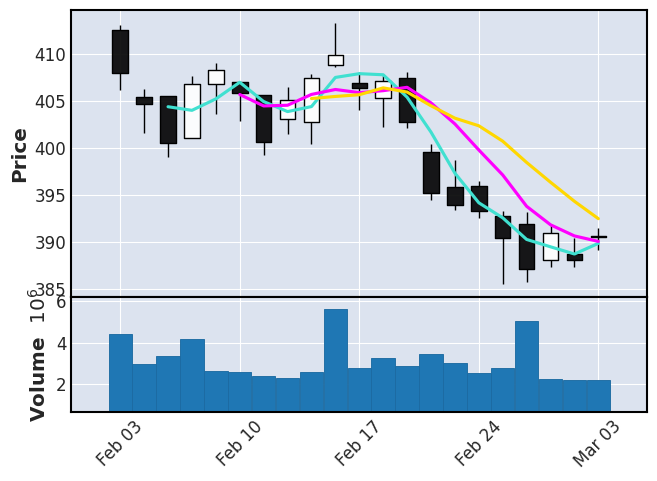

In [7]:
for symbol in stockPandasTot:
    stockPandas = stockPandasTot[symbol]
    print(symbol)
    mpf.plot(stockPandas.iloc[::-1],type='candle',mav=(3,6,9),volume=True)